# Multivariate quantiles and long horizon forecasting with N-HiTS
This nb was taken from [the PyTorch Forecasting documentation.](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/nhits.html)

We recommend running it here [https://colab.research.google.com/github/vrodriguezf/sertemp/blob/main/nbs/forecasting/NHiTS.ipynb](https://colab.research.google.com/github/vrodriguezf/sertemp/blob/main/nbs/forecasting/NHiTS.ipynb)

**pip install lightning pytorch_forecasting cpflows**

In [1]:
import time
import warnings
import pandas as pd
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss

warnings.filterwarnings("ignore")

c:\Users\aleja\workspace\SERTEMP-project-MAADM-UPM\.venv\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Load data


We generate a synthetic dataset to demonstrate the network's capabilities. The data consists of a quadratic trend and a seasonality component.


In [2]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


Before starting training, we need to split the dataset into a training and validation :py:class:`~pytorch_forecasting.data.timeseries.TimeSeriesDataSet`.

In [3]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-HiTS can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

batch_size = 128
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate baseline error


Our baseline model predicts future values by repeating the last know value. The resulting :py:class:`~pytorch_forecasting.metrics.SMAPE` is disappointing and should not be easy to beat.

In [4]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(0.5462)

## Train network


Finding the optimal learning rate using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/) is easy. The key hyperparameter of the :py:class:`~pytorch_forecasting.models.nhits.NHiTS` model is ``hidden_size``.

PyTorch Forecasting is flexible enough to use NHiTS with different loss functions, enabling not only point forecasts but also probabilistic ones. Here, we will demonstrate not only a typical quantile regression but a multivariate quantile regression with :py:class:`~pytorch_forecasting.metrics.distributions.MQF2DistributionLoss` which allows calculation sampling consistent paths along a prediction horizon. This allows calculation of quantiles, e.g. of the sum over the prediction horizon while still avoiding the accumulating error problem from auto-regressive methods such as DeepAR. One needs to install an additional package for this quantile function:

``pip install pytorch-forecasting[mqf2]``

In [5]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
model = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr: 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]
Learning rate set to 0.004786300923226385
Restoring states from the checkpoint path at c:\Users\aleja\workspace\SERTEMP-project-MAADM-UPM\.lr_find_488895ad-f094-4354-8cb1-18379028741c.ckpt
Restored all states from the checkpoint at c:\Users\aleja\workspace\SERTEMP-project-MAADM-UPM\.lr_find_488895ad-f094-4354-8cb1-18379028741c.ckpt


****** Tiempo búsqueda lr óptimo: 0 minutos y 16 segundos ******
****** suggested learning rate: 0.004786300923226385 ******


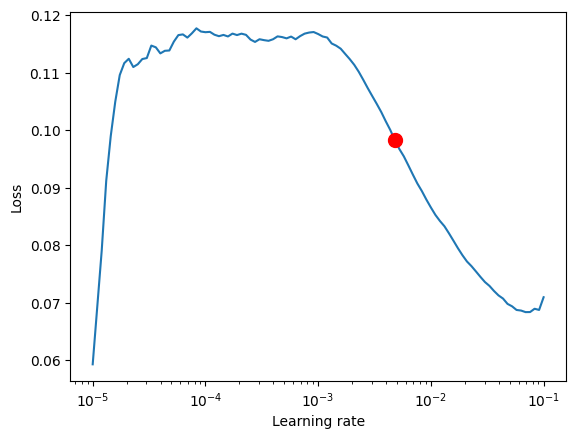

In [ ]:
start = time.time()

# find optimal learning rate
result = Tuner(trainer).lr_find(
    model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
model.hparams.learning_rate = result.suggestion()

minutos, segundos = divmod(time.time() - start, 60)
print(f"****** Tiempo búsqueda lr óptimo: {int(minutos)} minutos y {int(segundos)} segundos ******")
print(f"****** suggested learning rate: {result.suggestion()} ******")

fig = result.plot(show=True, suggest=True)
fig.show()

Fit model


In [7]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)

model = NHiTS.from_dataset(
    training,
    learning_rate=5e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

start = time.time()
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
minutos, segundos = divmod(time.time() - start, 60)
print(f"****** Tiempo entrenamiento NHiTS: {int(minutos)} minutos {int(segundos)} segundos ******")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 5.1 K  | train
1 | logging_metrics | ModuleList           | 0      | train
2 | embeddings      | MultiEmbedding       | 0      | train
3 | model           | NHiTS                | 35.7 K | train
-----------------------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 30/30 [00:05<00:00,  5.94it/s, v_num=51, train_loss_step=0.0252, val_loss=0.0384, train_loss_epoch=0.0218]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 30/30 [00:05<00:00,  5.91it/s, v_num=51, train_loss_step=0.0252, val_loss=0.0384, train_loss_epoch=0.0218]
****** Tiempo entrenamiento NHiTS: 0 minutos 25 segundos ******


### Evaluate Results


In [8]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

We predict on the validation dataset with :py:meth:`~pytorch_forecasting.models.base_model.BaseModel.predict` and calculate the error which is well below the baseline error

In [9]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(0.1916)

Looking at random samples from the validation set is always a good way to understand if the forecast is reasonable - and it is!


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


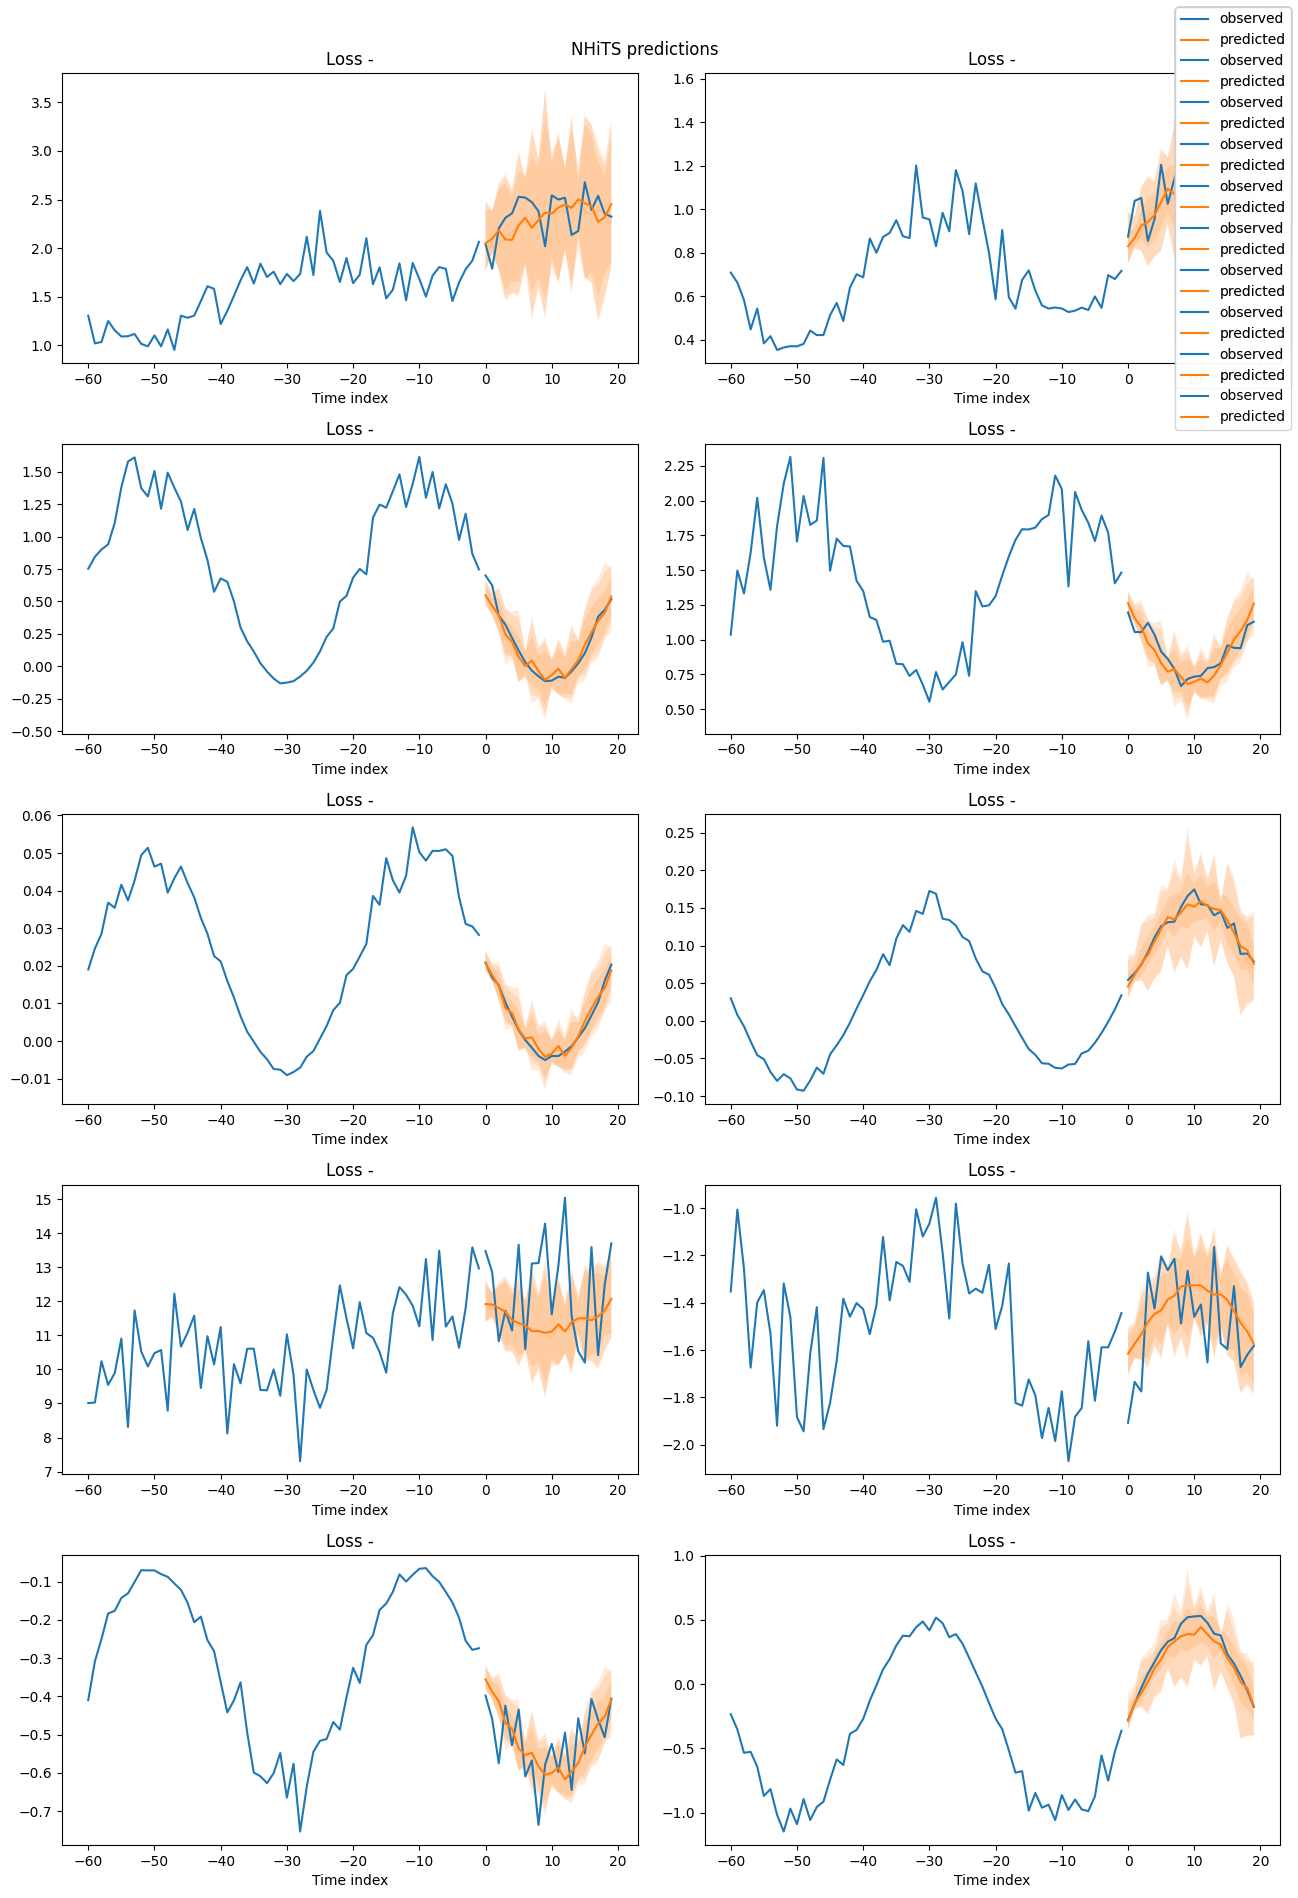

In [29]:
fig, axes = plt.subplots(5, 2, figsize=(13, 19))
axes = axes.flatten()
raw_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
for idx in range(10):
    # matplotlib.figure.Figure; https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.figure.Figure.html
    subfigure = best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True, ax=axes[idx])
plt.suptitle("NHiTS predictions")
plt.tight_layout()
plt.show()

## Interpret model


We can ask PyTorch Forecasting to decompose the prediction into blocks which focus on a different frequency spectrum, e.g. seasonality and trend with :py:meth:`~pytorch_forecasting.models.nhits.NHiTS.plot_interpretation`. This is a special feature of the :py:class:`~pytorch_forecasting.models.nhits.NHiTS` model and only possible because of its unique architecture. The results show that there seem to be many ways to explain the data and the algorithm does not always chooses the one making intuitive sense. This is partially down to the small number of time series we trained on (100). But it is also due because our forecasting period does not cover multiple seasonalities.

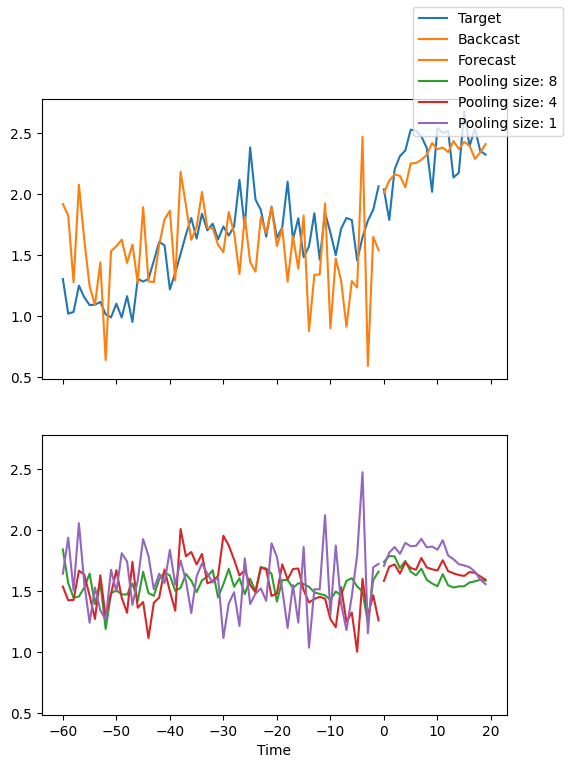

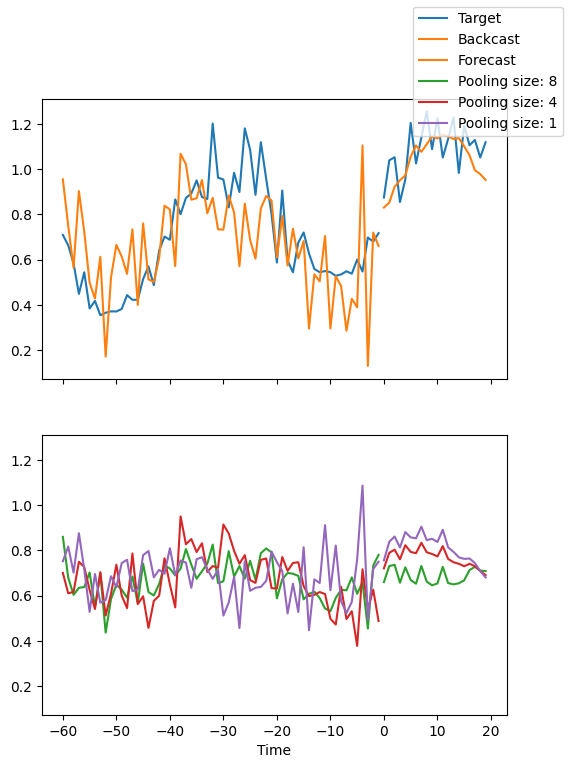

In [28]:
for idx in range(2):
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)

## Sampling from predictions


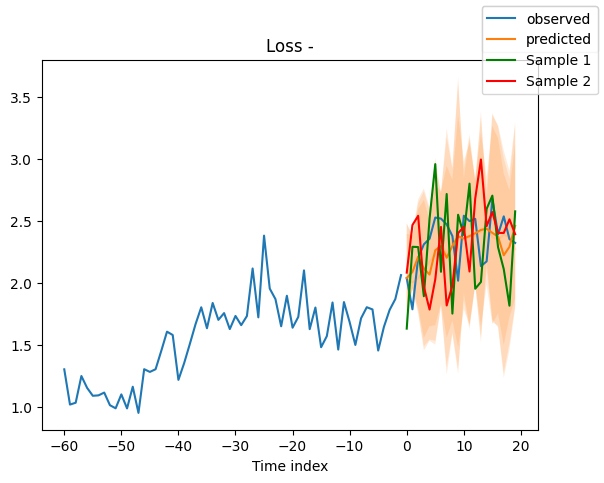

In [33]:
# sample 500 paths
samples = best_model.loss.sample(raw_predictions.output["prediction"][[0]], n_samples=500)[0]

fig = best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
ax = fig.get_axes()[0]
# plot first two sampled paths
ax.plot(samples[:, 0], color="g", label="Sample 1")
ax.plot(samples[:, 1], color="r", label="Sample 2")
fig.legend()
plt.show()

As expected, the variance of predictions is smaller within each sample than accross all samples.


In [34]:
print(f"Var(all samples) = {samples.var():.4f}")
print(f"Mean(Var(sample)) = {samples.var(0).mean():.4f}")

Var(all samples) = 0.1454
Mean(Var(sample)) = 0.1160


We can now do something new and plot the distribution of sums of forecasts over the entire prediction range.


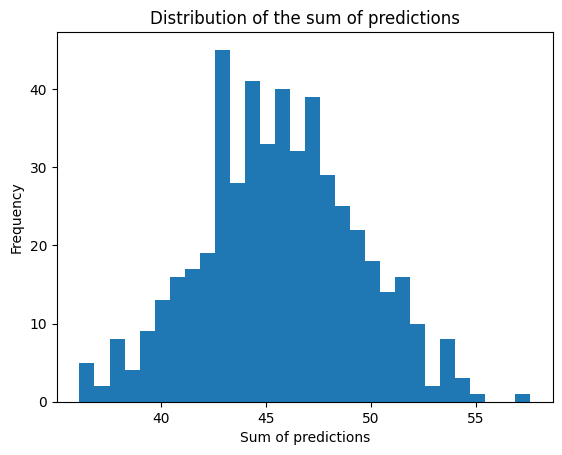

In [35]:
plt.hist(samples.sum(0).numpy(), bins=30)
plt.xlabel("Sum of predictions")
plt.ylabel("Frequency")
plt.title("Distribution of the sum of predictions")
plt.show()